# Model testing

In [1]:
import os
from pathlib import Path
import confinement_mode_classifier as cmc
import torchvision
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import re
import random
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Seed set to 42


Device: cuda:0


In [2]:

data_dir_path = '/compass/Shared/Users/bogdanov/vyzkumny_ukol/data/LHmode-detection-shots'
file_names = os.listdir(data_dir_path)


#Chose what shots will be used in notebook. Removed shots has different dimensions
batch_size = 32
shot_numbers = [re.search(r'shot(\d+)', file_name).group(1) for file_name in file_names]
removed_shots = ['13182', '20009']
shot_numbers = [valid_shot for valid_shot in shot_numbers if valid_shot not in removed_shots]

shots_for_testing = ['18130', '16773', '16534', '19094', '18133']
shots_for_validation = ['16769', '19379', '18057', '18132']

shot_df, test_df, _, _ = cmc.load_and_split_dataframes(path, shot_numbers, shots_for_testing, shots_for_validation=shots_for_validation)


In [3]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

model_path = f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/15-01-2024, 08-58-25 RIS1xRIS2_fc_classifier_training'


#TEST one camera model
# pretrained_model.load_state_dict(torch.load(f'{model_path}/model_fc_trained.pt'))
# pretrained_model.eval()
# pretrained_model.to(device)
# test_dataloader = cmc.get_dloader(test_df, path=path, batch_size=batch_size, shuffle=False, balance_data=False)


#TEST ensembled model
ensembled_model = cmc.TwoImagesModel(modelA=pretrained_model, modelB=pretrained_model, hidden_units=30).to(device)
ensembled_model.load_state_dict(torch.load(f'{model_path}/model.pt'))
ensembled_model.eval()
ensembled_model.to(device)
test_dataloader = cmc.get_two_imgs_dloader(test_df, path=path, batch_size=batch_size, shuffle=False, balance_data=False,
                                           second_img_opt='RIS2')

Seed set to 42


Device: cuda:0


Processing batches:   0%|          | 0/326 [00:00<?, ?it/s]

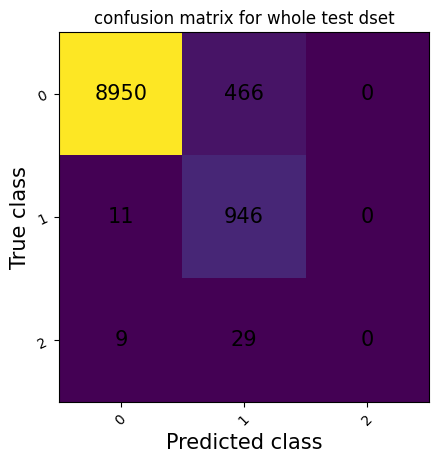

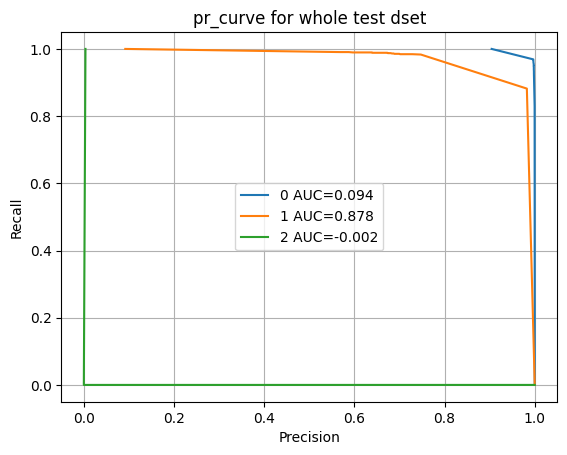

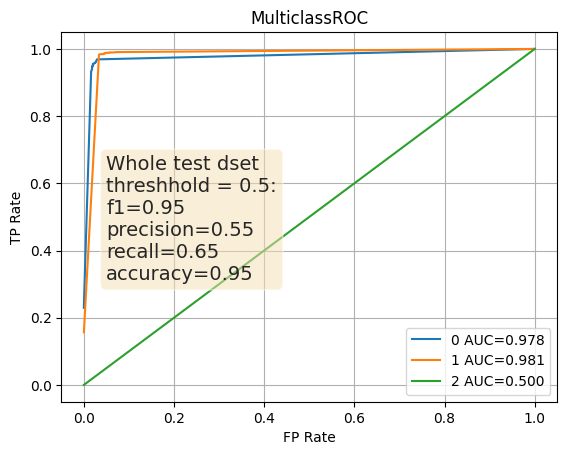

In [4]:
from importlib import reload
reload(cmc)
predictions_df, fig_confusion_matrix, f1, precision, recall, accuracy, pr_curve, roc_curve = cmc.test_model(model_path, 
                                                                                                            ensembled_model, test_dataloader
                                                                                                            )

In [5]:
shots_for_testing = list(map(int,shots_for_testing))

In [6]:
from importlib import reload
reload(cmc)
img_path = cmc.per_shot_test(path=model_path, shots=shots_for_testing, results_df=predictions_df)

Seed set to 42


Device: cuda:0


  0%|          | 0/5 [00:00<?, ?it/s]